## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [20]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import IPython
import sys, os, array, time
import serial 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, ReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight  
from imblearn.over_sampling import SMOTE
import openpyxl

**QUESTION:** Load dataset and display some lines of the csv file.

In [ ]:
Raw_data = pd.read_excel('./ai4i2020.xlsx')
print(Raw_data.iloc[0])
print("---")
print(Raw_data.iloc[150])
print("---")

UDI                             1
Product ID                 M14860
Type                            M
Air temperature [K]         298.1
Process temperature [K]     308.6
Rotational speed [rpm]       1551
Torque [Nm]                  42.8
Tool wear [min]                 0
Machine failure                 0
TWF                             0
HDF                             0
PWF                             0
OSF                             0
RNF                             0
Name: 0, dtype: object
---
UDI                           151
Product ID                 L47330
Type                            L
Air temperature [K]         298.4
Process temperature [K]     308.3
Rotational speed [rpm]       1422
Torque [Nm]                  42.7
Tool wear [min]               186
Machine failure                 0
TWF                             0
HDF                             0
PWF                             0
OSF                             0
RNF                             0
Name: 150, dtype: obj

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

Machine failure
0    9661
1     339
Name: count, dtype: int64


Text(0.5, 1.0, 'failed and functionnal machines')

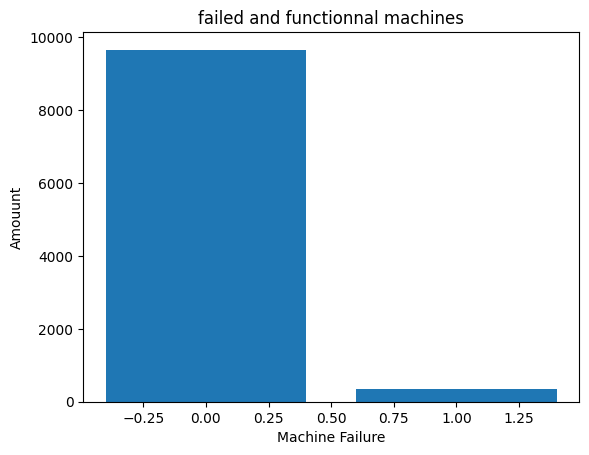

In [ ]:
compte = Raw_data["Machine failure"].value_counts()
print(compte)
plt.bar(compte.index, compte.values)
plt.xlabel('Machine Failure')
plt.ylabel('Amouunt')
plt.title('failed and functionnal machines')

**ANALYSIS QUESTION:** What do you observe?

Much more working machine than dysfunctional ones.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

Text(0.5, 1.0, 'Amount of failure types')

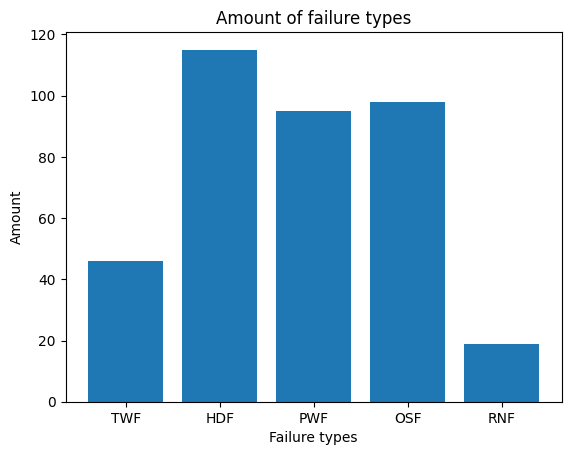

In [23]:
plt.bar(['TWF','HDF','PWF','OSF','RNF'],[Raw_data['TWF'].sum(),Raw_data['HDF'].sum(),Raw_data['PWF'].sum(),Raw_data['OSF'].sum(),Raw_data['RNF'].sum()])
plt.xlabel('Failure types')
plt.ylabel('Amount')
plt.title('Amount of failure types')

**ANALYSIS QUESTION:** What do you observe?

There are 3 principal failure types (HDF, PWF, OSF) and 2 less frequent failures (TWF, RNF). The random failures (RNF) ar the less frequent failures.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

C:\Users\rabie\AppData\Local\Temp\ipykernel_3952\1597477434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['No specific data'] = (~(filtered_data['TWF']==1) & ~(filtered_data['HDF']==1) & ~(filtered_data['PWF']==1) & ~(filtered_data['OSF']==1) & ~(filtered_data['RNF']==1) )


Text(0.5, 1.0, 'Amount of failure types for failed machines only')

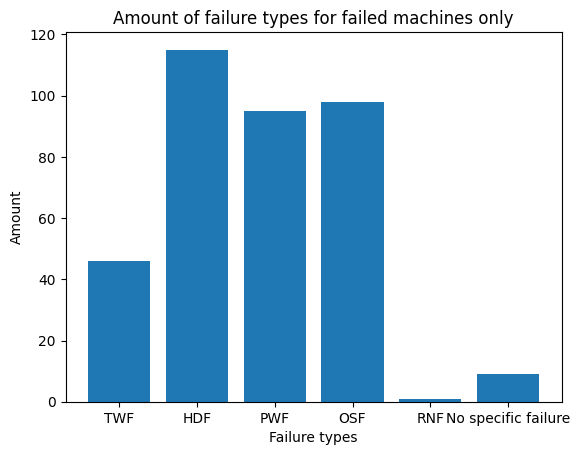

In [24]:

filtered_data = Raw_data[Raw_data['Machine failure']==1]
#print(filtered_data.iloc[0])
filtered_data['No specific data'] = (~(filtered_data['TWF']==1) & ~(filtered_data['HDF']==1) & ~(filtered_data['PWF']==1) & ~(filtered_data['OSF']==1) & ~(filtered_data['RNF']==1) )
#print(filtered_data)
#test = filtered_data[filtered_data['No specific data']==True]
#print(test)
plt.bar(['TWF','HDF','PWF','OSF','RNF','No specific failure'],[filtered_data['TWF'].sum(),filtered_data['HDF'].sum(),filtered_data['PWF'].sum(),filtered_data['OSF'].sum(),filtered_data['RNF'].sum(),filtered_data['No specific data'].sum()])
plt.xlabel('Failure types')
plt.ylabel('Amount')
plt.title('Amount of failure types for failed machines only')

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

We observe that the distribution remains quite the same except for random failres (RNF) which means that random failures don't lead to machine failure as described in the dataset. We also notice that some machine can be dysfunctional without being linked to a specific failure.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
Raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

To train the model we'll use columns 3 to 7 which are data, the outputs will be the specific failures but not the RNF type that doesn't correspond to a machine failure. We will also use a column which is the opposite of machine failure ( ie. Machine functionnal)

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [30]:
Raw_data['Functionnal']=1-Raw_data['Machine failure']
data_df = Raw_data.drop(['Type','UDI','Product ID','RNF', 'Machine failure'], axis=1)
print(data_df.iloc[0])
print("---")
data_inputs = data_df.iloc[:,0:5]
print(data_inputs.iloc[0])
print("---")
data_outputs = data_df.iloc[:,5:]
print(data_outputs.iloc[0])
X_train, X_test, Y_train, Y_test = train_test_split(data_inputs, data_outputs, test_size=0.3, random_state=42)
X_test,X_valid,Y_test,Y_valid = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
output_labels = data_outputs.columns.tolist()
print(output_labels)
print(X_train.iloc[0])
print(Y_train.iloc[0])






Air temperature [K]         298.1
Process temperature [K]     308.6
Rotational speed [rpm]     1551.0
Torque [Nm]                  42.8
Tool wear [min]               0.0
TWF                           0.0
HDF                           0.0
PWF                           0.0
OSF                           0.0
Functionnal                   1.0
Name: 0, dtype: float64
---
Air temperature [K]         298.1
Process temperature [K]     308.6
Rotational speed [rpm]     1551.0
Torque [Nm]                  42.8
Tool wear [min]               0.0
Name: 0, dtype: float64
---
TWF            0
HDF            0
PWF            0
OSF            0
Functionnal    1
Name: 0, dtype: int64
['TWF', 'HDF', 'PWF', 'OSF', 'Functionnal']
Air temperature [K]         297.2
Process temperature [K]     308.2
Rotational speed [rpm]     1678.0
Torque [Nm]                  28.1
Tool wear [min]             133.0
Name: 9069, dtype: float64
TWF            0
HDF            0
PWF            0
OSF            0
Functionnal    1
N

**QUESTION** Code below the model architecture

In [ ]:

inputs = Input(shape=(5,))  

x = Dense(512, kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)

x = Dense(128, kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)

x = Dense(64, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)

x = Dense(32, kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)

outputs = Dense(5, activation='softmax')(x)

#Model defintion
unbalanced = tf.keras.Model(inputs=inputs, outputs=outputs, name="unbalanced")

unbalanced.summary()

unbalanced.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

#Training parameters
nb_epochs = 50
batch_size = 120

#Train the model
training_history = unbalanced.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),epochs=nb_epochs,batch_size=batch_size)


Model: "unbalanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 512)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 181,765 (710.02 KB)

 Trainable params: 179,781 (702.27 KB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2276 - loss: 3.3259 - val_accuracy: 0.0073 - val_loss: 8.4511
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3528 - loss: 3.0718 - val_accuracy: 0.0073 - val_loss: 4.8024
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4775 - loss: 2.8567 - val_accuracy: 0.2847 - val_loss: 3.6239
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5883 - loss: 2.6826 - val_accuracy: 0.5507 - val_loss: 3.0937
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6811 - loss: 2.5356 - val_accuracy: 0.7887 - val_loss: 2.6460
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7650 - loss: 2.3882 - val_accuracy: 0.8360 - val_loss: 2.4108
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8260 - loss: 2.2559 - val_accuracy: 0.8920 - val_loss: 2.2470
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8689 - loss: 2.1509 - val_accuracy: 0.9260 - v

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9673 - loss: 0.5954
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9745 - loss: 0.5807 
Performance on the TRAIN set, ACCURACY= 0.9661428332328796
Performance on the TEST set, ACCURACY= 0.9700000286102295


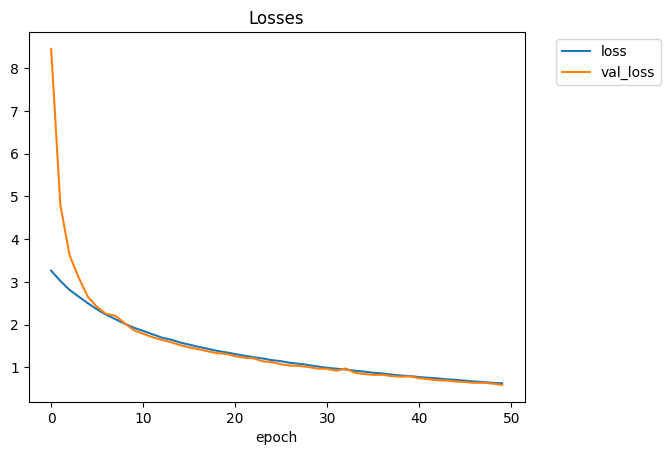

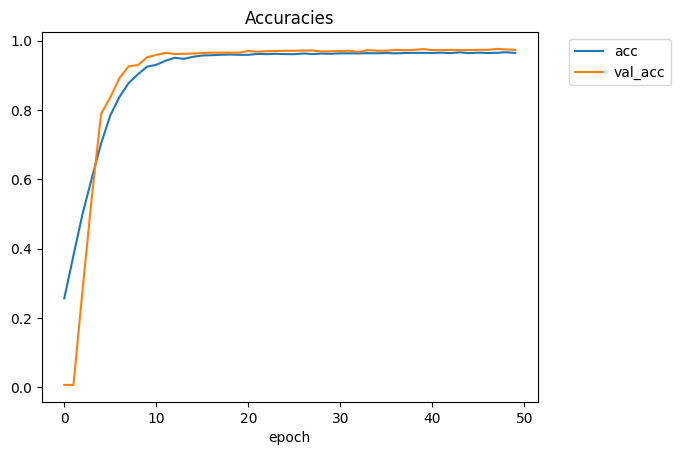

In [ ]:
#compute the accuracy and training and test sets
loss_train, acc_train = unbalanced.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = unbalanced.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

def display_training_curves(training_history):
  #display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.title("Losses")
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.title("Accuracies")
  plt.show()
  
display_training_curves(training_history)



**QUESTION** Plot the confusion matrix and the classification report

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1500, 5)


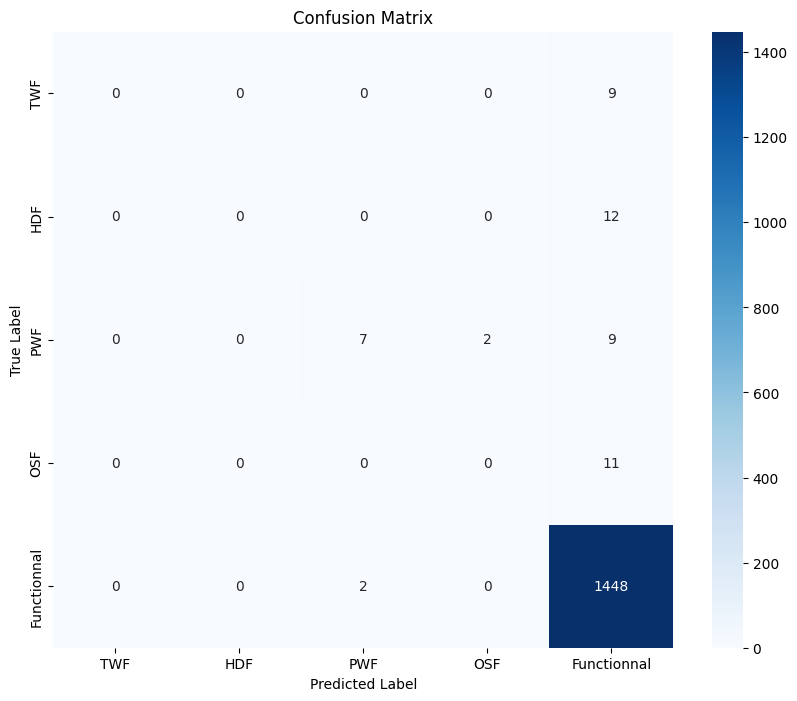

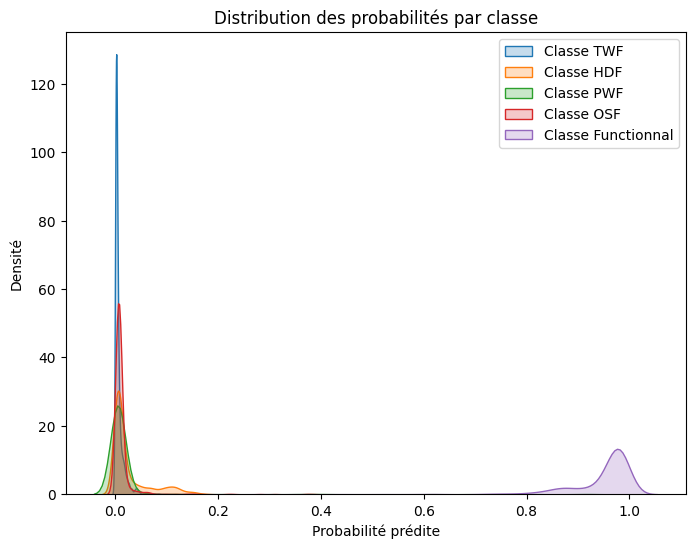

              precision    recall  f1-score   support

         TWF       0.00      0.00      0.00         9
         HDF       0.00      0.00      0.00        12
         PWF       0.78      0.39      0.52        18
         OSF       0.00      0.00      0.00        11
 Functionnal       0.97      1.00      0.99      1450

    accuracy                           0.97      1500
   macro avg       0.35      0.28      0.30      1500
weighted avg       0.95      0.97      0.96      1500



c:\Users\rabie\OneDrive\Bureau\ISMIN 2A\S8\Embeded_AI\embeded_ia\ai_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rabie\OneDrive\Bureau\ISMIN 2A\S8\Embeded_AI\embeded_ia\ai_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rabie\OneDrive\Bureau\ISMIN 2A\S8\Embeded_AI\embeded_ia\ai_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [ ]:

#Predictions
Y_pred_probs = unbalanced.predict(X_test)
Y_pred = np.argmax(Y_pred_probs, axis=1) 
Y_true = np.argmax(Y_test, axis=1)
print(Y_test.shape)

#Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=output_labels, yticklabels=output_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Probability distribution for each class
plt.figure(figsize=(8,6))
for i in range(5):
    sns.kdeplot(Y_pred_probs[:, i], label=f'Classe {output_labels[i]}', fill=True)

plt.xlabel("Probabilité prédite")
plt.ylabel("Densité")
plt.title("Distribution des probabilités par classe")
plt.legend()
plt.show()

#Report
report = classification_report(Y_true, Y_pred, target_names=output_labels)
print(report)

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

The class "functionnal" is much more represented in the dataset which leads the model to be efficient but only for this class, as other class are much less represented it's like the model doesn't care about those classes. In the end, the model looks efficient but it is not.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [34]:
Raw_data2 = pd.read_excel('./ai4i2020.xlsx')
Raw_data2["Functionnal"] = 1-Raw_data2['Machine failure']
data_df2 = Raw_data2.drop(['Type','UDI','Product ID','RNF', 'Machine failure'], axis=1)
filtered_df = data_df2[data_df2.iloc[:,5:].sum(axis=1) == 1]
data_inputs = pd.get_dummies(filtered_df.iloc[:,0:5])
data_outputs = filtered_df.iloc[:,5:]

def flat(row):
    if row['Functionnal'] == 1:
        return 1
    elif row['TWF'] == 1:
        return 2
    elif row['HDF'] == 1:
        return 3
    elif row['PWF'] == 1:
        return 4
    elif row['OSF'] == 1:
        return 5
    return 0

outputs_single = data_outputs.apply(flat,axis=1)
smote = SMOTE(sampling_strategy='auto', random_state=42) 
X_resampled, Y_resampled = smote.fit_resample(data_inputs, outputs_single)

Y_resampled_full = np.zeros((Y_resampled.shape[0], 5))
Y_resampled_full[np.arange(Y_resampled.shape[0]), Y_resampled - 1] = 1

X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled_full, test_size=0.3, random_state=42)
X_test,X_valid,Y_test,Y_valid = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)


print(f'Number of elements in X_train: {len(X_train)}')
print(f'Number of elements in Y_train: {len(Y_train)}')
print(f'Number of elements in X_test: {len(X_test)}')
print(f'Number of elements in Y_test: {len(Y_test)}')
print(f'Number of elements in X_val: {len(X_valid)}')
print(f'Number of elements in Y_val: {len(Y_valid)}') 
output_labels = data_outputs.columns.tolist()
print(output_labels)



Number of elements in X_train: 33813
Number of elements in Y_train: 33813
Number of elements in X_test: 7246
Number of elements in Y_test: 7246
Number of elements in X_val: 7246
Number of elements in Y_val: 7246
['TWF', 'HDF', 'PWF', 'OSF', 'Functionnal']


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

To balance the dataset I used the smote technique that automatically creates data for all the minoritory classes. This technique creates data so that minoritory classes get as much values as the dominant class, thanks to smote the dataset is balanced and every class gets a weight of 1.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [35]:

inputs = Input(shape=(X_train.shape[1],))  

x = Dense(512,activation='relu')(inputs)
x = Dropout(0.1)(x)

x = Dense(128,activation='relu')(x)
x = Dropout(0.1)(x)


x = Dense(64,activation='relu')(x)
x = Dropout(0.1)(x)


x = Dense(32,activation='relu')(x)
x = Dropout(0.1)(x)


outputs = Dense(5, activation='softmax')(x)

#Model defintion
weighted = tf.keras.Model(inputs=inputs, outputs=outputs, name="weighted")

weighted.summary()

weighted.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])



#Training parameters
nb_epochs = 70
batch_size = 100

#Train the model
training_history_weighted = weighted.fit(np.array(X_train,dtype=np.float32), np.array(Y_train,dtype=np.float32),validation_data=(np.array(X_valid,dtype=np.float32), np.array(Y_valid,dtype=np.float32)),epochs=nb_epochs,batch_size=batch_size)



Model: "weighted"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 512)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,237 (309.52 KB)

 Trainable params: 79,237 (309.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2385 - loss: 19.7239 - val_accuracy: 0.3613 - val_loss: 1.5127
Epoch 2/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2746 - loss: 2.9390 - val_accuracy: 0.2927 - val_loss: 1.5265
Epoch 3/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2719 - loss: 1.9634 - val_accuracy: 0.2911 - val_loss: 1.5604
Epoch 4/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2864 - loss: 1.6902 - val_accuracy: 0.3859 - val_loss: 1.4353
Epoch 5/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3094 - loss: 1.5674 - val_accuracy: 0.4289 - val_loss: 1.3114
Epoch 6/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3497 - loss: 1.4740 - val_accuracy: 0.4273 - val_loss: 1.2266
Epoch 7/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3689 - loss: 1.3923 - val_accuracy: 0.4594 - val_loss: 1.1093
Epoch 8/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4046 - loss: 1.3085 - val_accuracy: 0

**QUESTION** Code below the algorithms allowing to train model


In [36]:
## see upwards

**QUESTION** Plot the confusion matrix and the classification report

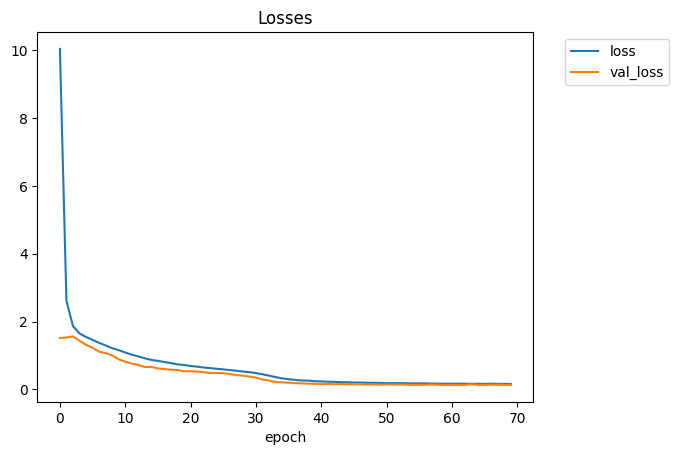

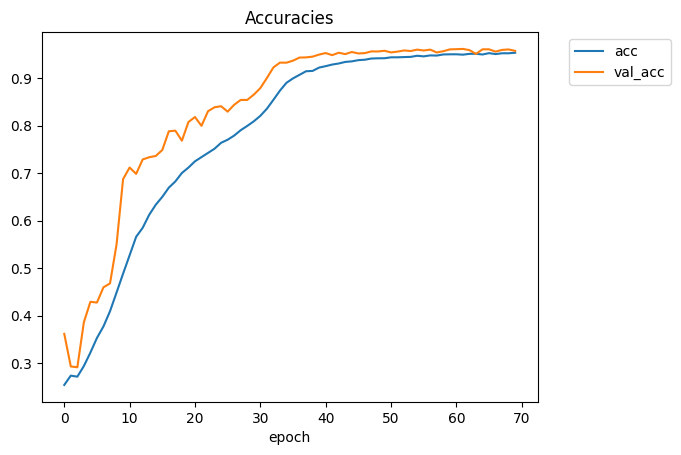

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


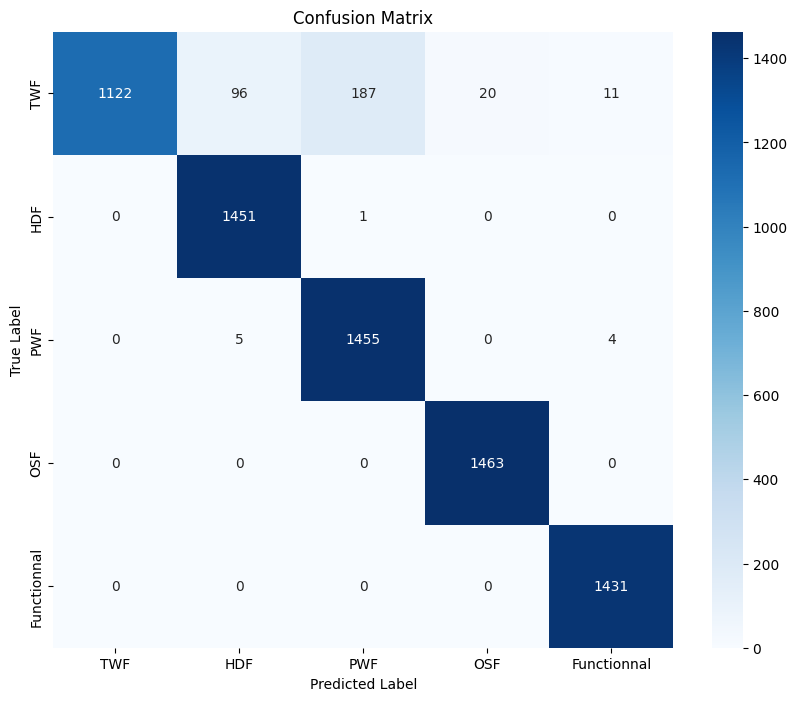

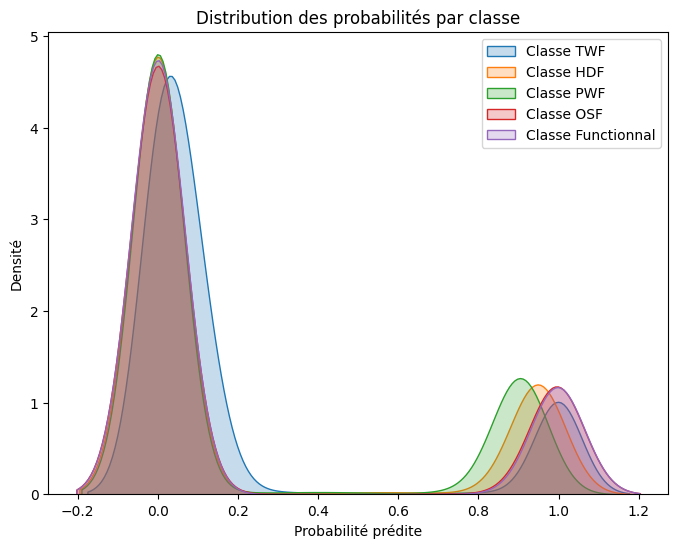

              precision    recall  f1-score   support

         TWF       1.00      0.78      0.88      1436
         HDF       0.93      1.00      0.97      1452
         PWF       0.89      0.99      0.94      1464
         OSF       0.99      1.00      0.99      1463
 Functionnal       0.99      1.00      0.99      1431

    accuracy                           0.96      7246
   macro avg       0.96      0.95      0.95      7246
weighted avg       0.96      0.96      0.95      7246



In [ ]:

display_training_curves(training_history_weighted)

#Predictions
Y_pred_probs = weighted.predict(np.array(X_test,dtype=np.float32))
Y_pred = np.argmax(Y_pred_probs, axis=1) 
Y_true = np.argmax(np.array(Y_test,dtype=np.float32), axis=1)

#Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=output_labels, yticklabels=output_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Probability distribution for each class
plt.figure(figsize=(8,6))
for i in range(5):
    sns.kdeplot(Y_pred_probs[:, i], label=f'Classe {output_labels[i]}', fill=True)

plt.xlabel("Probabilité prédite")
plt.ylabel("Densité")
plt.title("Distribution des probabilités par classe")
plt.legend()
plt.show()

#Report
report = classification_report(Y_true, Y_pred, target_names=output_labels)
print(report)

In [48]:

np.save('numpy_data/X_train.npy',np.array(X_train,dtype=np.float32))
np.save('numpy_data/X_test.npy',np.array(X_test,dtype=np.float32))
np.save('numpy_data/X_valid.npy',np.array(X_valid,dtype=np.float32))
np.save('numpy_data/Y_train.npy',np.array(Y_train,dtype=np.float32))
np.save('numpy_data/Y_test.npy',np.array(Y_test,dtype=np.float32))
np.save('numpy_data/Y_valid.npy',np.array(Y_valid,dtype=np.float32))
converter = tf.lite.TFLiteConverter.from_keras_model(weighted)
tflite_model = converter.convert()
open("Panhelleux_Rabier_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rabie\AppData\Local\Temp\tmpftjgw37k\assets


INFO:tensorflow:Assets written to: C:\Users\rabie\AppData\Local\Temp\tmpftjgw37k\assets


Saved artifact at 'C:\Users\rabie\AppData\Local\Temp\tmpftjgw37k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='keras_tensor_120')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2217933352272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219685571152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217933351696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217916868816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217937042320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217937042704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217937041360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217937043088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217922720016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217922721360: TensorSpec(shape=(), dtype=tf.resource, name=None)


319776

The cell bellow allows us to export 10%nof the validation dataset to perform the model's validation on target.

In [50]:
Y_valid=np.array(Y_valid,dtype=np.float32)
Y_valid_resized = Y_valid.reshape(-1, 1, 1, 5)
np.save('numpy_data/Y_valid_resized.npy',Y_valid_resized)
X_valid=np.array(X_valid,dtype=np.float32)
X_valid_resized = X_valid.reshape(-1, 1, 1, 5)
np.save('numpy_data/X_valid_resized.npy', X_valid_resized)
print(X_valid_resized.shape)

X_valid_resized_mini, X_trash, Y_valid_resized_mini, Y_trash = train_test_split(X_valid_resized, Y_valid_resized, test_size=0.9, random_state=42)
np.save('numpy_data/X_valid_resized_mini.npy',X_valid_resized_mini)
np.save('numpy_data/Y_valid_resized_mini.npy',Y_valid_resized_mini)
print(X_valid_resized_mini.shape)

(7246, 1, 1, 5)
(724, 1, 1, 5)


**ANALYSIS QUESTION** What do you observe? What can you conclude?

The difference is flabbergasting, we can clearly see that with balanced data the model is able to make real predicction that take into account every classes. Thanks to the balancing of the dataset and a little change of architecture we went to a fakely efficient model to a really efficient model that fits onto a microcontroller.


